Evaluation code for CAMI strain-madness using gold-standard database.

# Imports / Preambles

In [1]:
%env CHRONOSTRAIN_INI=../chronostrain/chronostrain.ini
%env CHRONOSTRAIN_CACHE_DIR=./cache
%env CHRONOSTRAIN_DB_DIR=./db_placeholder
%env CHRONOSTRAIN_DB_JSON=none
%env CHRONOSTRAIN_LOG_INI=logging.ini
%env JAX_PLATFORM_NAME=cpu

from pathlib import Path
from base import StrainAbundanceProfile
from ground_truth import filter_profiles, restrict_profile, SpeciesLabel
from chronostrain_eval import extract_chronostrain_prediction, ChronoStrainInferenceResult, calculate_marker_genome_ratio
from straingst_eval import StrainGEInferenceResult, extract_straingst_prediction
from mgems_eval import MGEMSFlatInferenceResult, extract_mgems_prediction
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sb
from typing import *
import pickle
    

import numpy as np
import pandas as pd
import sklearn, sklearn.metrics

from tqdm.notebook import tqdm

env: CHRONOSTRAIN_INI=../chronostrain/chronostrain.ini
env: CHRONOSTRAIN_CACHE_DIR=./cache
env: CHRONOSTRAIN_DB_DIR=./db_placeholder
env: CHRONOSTRAIN_DB_JSON=none
env: CHRONOSTRAIN_LOG_INI=logging.ini
env: JAX_PLATFORM_NAME=cpu


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = False
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

# import os
# os.environ["PATH"] = "{}:{}".format(os.environ["PATH"], "/usr/bin")

# Global settings

In [3]:
EPSILON_FOR_LOG_PADDING = 1e-7
RENORMALIZE_PER_SPECIES = False

# Pre-computation

In [4]:
pkl_cache_path = Path("./notebook_cache")

In [5]:
# # ChronoStrain database marker/genome ratios

# cs_gold_standard_marker_genome_ratios_ecoli = calculate_marker_genome_ratio(Path("/mnt/e/CAMI_strain_madness/inference/databases/chronostrain/e_coli/gold_standard_only.json"))
# cs_gold_standard_marker_genome_ratios_saureus = calculate_marker_genome_ratio(Path("/mnt/e/CAMI_strain_madness/inference/databases/chronostrain/s_aureus/gold_standard_only.json"))
# cs_gold_standard_marker_genome_ratios_spneumoniae = calculate_marker_genome_ratio(Path("/mnt/e/CAMI_strain_madness/inference/databases/chronostrain/s_pneumoniae/gold_standard_only.json"))
# cs_gold_standard_marker_genome_ratios_kpneumoniae = calculate_marker_genome_ratio(Path("/mnt/e/CAMI_strain_madness/inference/databases/chronostrain/k_pneumoniae/gold_standard_only.json"))
# cs_gold_standard_marker_genome_ratios_efaecium = calculate_marker_genome_ratio(Path("/mnt/e/CAMI_strain_madness/inference/databases/chronostrain/e_faecium/gold_standard_only.json"))

# # Save these ratios to disk.

# pkl_cache_path.mkdir(exist_ok=True)
# with open(pkl_cache_path / "ecoli_gold_standard_only_marker_ratios.pkl", "wb") as f:
#     pickle.dump(cs_gold_standard_marker_genome_ratios_ecoli, f)
# with open(pkl_cache_path / "saureus_gold_standard_only_marker_ratios.pkl", "wb") as f:
#     pickle.dump(cs_gold_standard_marker_genome_ratios_saureus, f)
# with open(pkl_cache_path / "spneumoniae_gold_standard_only_marker_ratios.pkl", "wb") as f:
#     pickle.dump(cs_gold_standard_marker_genome_ratios_spneumoniae, f)
# with open(pkl_cache_path / "kpneumoniae_gold_standard_only_marker_ratios.pkl", "wb") as f:
#     pickle.dump(cs_gold_standard_marker_genome_ratios_kpneumoniae, f)
# with open(pkl_cache_path / "efaecium_gold_standard_only_marker_ratios.pkl", "wb") as f:
#     pickle.dump(cs_gold_standard_marker_genome_ratios_efaecium, f)

In [6]:
# Load these dicts from file instead, if the above cell was run at least once.
with open(pkl_cache_path / "ecoli_gold_standard_only_marker_ratios.pkl", "rb") as f:
    cs_gold_standard_marker_genome_ratios_ecoli = pickle.load(f)
with open(pkl_cache_path / "saureus_gold_standard_only_marker_ratios.pkl", "rb") as f:
    cs_gold_standard_marker_genome_ratios_saureus = pickle.load(f)
with open(pkl_cache_path / "spneumoniae_gold_standard_only_marker_ratios.pkl", "rb") as f:
    cs_gold_standard_marker_genome_ratios_spneumoniae = pickle.load(f)
with open(pkl_cache_path / "kpneumoniae_gold_standard_only_marker_ratios.pkl", "rb") as f:
    cs_gold_standard_marker_genome_ratios_kpneumoniae = pickle.load(f)
with open(pkl_cache_path / "efaecium_gold_standard_only_marker_ratios.pkl", "rb") as f:
    cs_gold_standard_marker_genome_ratios_efaecium = pickle.load(f)

# Eval Overall

## Run Evaluation

In [7]:
def calc_errors(pred_profile: StrainAbundanceProfile, true_profile: StrainAbundanceProfile, eps, renormalize: bool = True, filter_lb: float = 0.0):
    _truth = true_profile.abundance_ratios
    if len(pred_profile.abundance_ratios.shape) == 2:
        # Chronostrain samples: Evaluate the median trajectory.
        _pred = np.median(pred_profile.abundance_ratios, axis=0)
    elif len(pred_profile.abundance_ratios.shape) == 1:
        _pred = pred_profile.abundance_ratios
    else:
        raise ValueError("Don't know what to do with abundance profile of shape {}".format(pred_profile.abundance_ratios.shape))

    assert len(_pred.shape) == len(_truth.shape)

    if renormalize:
        _pred = _pred / np.sum(_pred)
        _truth = _truth / np.sum(_truth)

    # Filter by lower bound. (if LB = 0.0, then this bit of code does nothing.)
    _locs, = np.where(_truth > filter_lb)
    _truth =  _truth[_locs]
    _pred =  _pred[_locs]
        
    # Evaluate errors.
    l1_error = np.abs(_pred - _truth).sum()
    rms_log_error = np.sqrt(np.mean(np.square(
        np.log10(_pred + eps) - np.log10(_truth + eps)
    )))
    
    return l1_error, rms_log_error

In [23]:
# same code as above, but in a loop


def evaluate_all(
    species_label: SpeciesLabel, chronostrain_subdir: str, 
    chronostrain_marker_genome_ratios,
    eps: float = 1e-6,
    PI_BAR_POSTERIOR_FILTER: float = 0.0, STRAINGST_SCORE_FILTER: float = 0.0, MGEMS_ABUND_FILTER: float = 0.0,
    renormalize_before_eval: bool = True
) -> pd.DataFrame:
    df_entries = []
    total_abunds = []

    LOAD_SPARSE_MODEL = False
    if LOAD_SPARSE_MODEL:
        model_type_subdir = 'sparse_model'
    else:
        model_type_subdir = 'dense_model'
    
    for sample_tag, profile_df in tqdm(filter_profiles("../../data/gs_strain_madness_short_long.profile.txt"), total=100):
        sample_id = int(sample_tag.split("_")[-1])
        true_profile, true_total_abund = restrict_profile(profile_df, species_label, renormalize=renormalize_before_eval)
        
        try:
            # Dense-mode (Simple softmax) inference
            # Run 1: Each timepoint individually.
            chronostrain_inference_dir = Path(f"/mnt/e/CAMI_strain_madness/inference/output/{chronostrain_subdir}/sample_{sample_id}/{model_type_subdir}")
            chronostrain_inference_result = extract_chronostrain_prediction(chronostrain_inference_dir, sparse=LOAD_SPARSE_MODEL, marker_genome_ratios=chronostrain_marker_genome_ratios, n_timepoints=1)
            chronostrain_pred_profile = chronostrain_inference_result.to_profile(true_profile.strain_ids, posterior_lb=PI_BAR_POSTERIOR_FILTER, timepoint_index=0)
            l1, rmsl = calc_errors(chronostrain_pred_profile, true_profile, eps, renormalize=renormalize_before_eval)
            df_entries.append({
                "Sample": sample_id,
                "Method": "ChronoStrain",
                "L1": l1,
                "RMSLE": rmsl,
                "SpeciesAbundance": true_total_abund
            })
        except FileNotFoundError as e:
            pass
    
        try:
            strainge_inference_dir = Path(f"/mnt/e/CAMI_strain_madness/inference/output/straingst_gold_standard_only/sample_{sample_id}")
            strainge_inference_result = extract_straingst_prediction(strainge_inference_dir)
            strainge_pred_profile = strainge_inference_result.to_profile(true_profile.strain_ids, score_lb=STRAINGST_SCORE_FILTER)
            l1, rmsl = calc_errors(strainge_pred_profile, true_profile, eps, renormalize=renormalize_before_eval)
            df_entries.append({
                "Sample": sample_id,
                "Method": "StrainGE",
                "L1": l1,
                "RMSLE": rmsl,
                "SpeciesAbundance": true_total_abund
            })
        except FileNotFoundError:
            pass
    
        try:
            mgems_flat_inference_dir = Path(f"/mnt/e/CAMI_strain_madness/inference/output/mgems_gold_standard_only/sample_{sample_id}")
            mgems_flat_inference_result = extract_mgems_prediction(mgems_flat_inference_dir, Path("/mnt/e/CAMI_strain_madness/inference/databases/mgems/gold_standard_only/ref_info.tsv"))
            mgems_flat_pred_profile = mgems_flat_inference_result.to_profile(true_profile.strain_ids, mgems_abund_lb=MGEMS_ABUND_FILTER)
            # if sample_id
            # MGEMS_DF_SAMPLE = mgems_flat_inference_result.abund_df
            l1, rmsl = calc_errors(mgems_flat_pred_profile, true_profile, eps, renormalize=renormalize_before_eval)
            df_entries.append({
                "Sample": sample_id,
                "Method": "mGEMS",
                "L1": l1,
                "RMSLE": rmsl,
                "SpeciesAbundance": true_total_abund
            })
        except FileNotFoundError:
            pass
            
    return np.array(total_abunds), pd.DataFrame(df_entries)


# =========== Data loading helper.

def evaluate_each_genome(
    species_label: SpeciesLabel, chronostrain_subdir: str, 
    chronostrain_marker_genome_ratios: Dict[str, float],
    PI_BAR_POSTERIOR_FILTER: float = 0.0, STRAINGST_SCORE_FILTER: float = 0.0, MGEMS_ABUND_FILTER: float = 0.0,
    renormalize: bool = True
) -> pd.DataFrame:
    df_entries = []

    for sample_tag, profile_df in tqdm(filter_profiles("../../data/gs_strain_madness_short_long.profile.txt"), total=100):
        sample_id = int(sample_tag.split("_")[-1])
        true_profile, true_total_abund = restrict_profile(profile_df, species_label, renormalize=renormalize)
        _truth = true_profile.abundance_ratios

        LOAD_SPARSE_MODEL = False
        if LOAD_SPARSE_MODEL:
            model_type_subdir = 'sparse_model'
        else:
            model_type_subdir = 'dense_model'

        try:
            # Dense-mode (Simple softmax) inference
            chronostrain_inference_dir = Path(f"/mnt/e/CAMI_strain_madness/inference/output/{chronostrain_subdir}/sample_{sample_id}/{model_type_subdir}")
            chronostrain_inference_result = extract_chronostrain_prediction(chronostrain_inference_dir, sparse=LOAD_SPARSE_MODEL, marker_genome_ratios=chronostrain_marker_genome_ratios, n_timepoints=1)
            chronostrain_pred_profile = chronostrain_inference_result.to_profile(true_profile.strain_ids, posterior_lb=PI_BAR_POSTERIOR_FILTER, renormalize=renormalize)
            _cs_pred = chronostrain_pred_profile.abundance_ratios
            _cs_pred = np.median(_cs_pred, axis=0)
            for s1, s2, t, cs_p in zip(true_profile.strain_ids, chronostrain_pred_profile.strain_ids, _truth, _cs_pred):
                assert s1 == s2
                df_entries.append({
                    'Sample': sample_id, 'Strain': s1, 'Truth': t,
                    'Pred': cs_p, 'Method': 'ChronoStrain'
                })
        except FileNotFoundError as e:
            pass

        # StrainGE
        try:
            strainge_inference_dir = Path(f"/mnt/e/CAMI_strain_madness/inference/output/straingst_gold_standard_only/sample_{sample_id}")
            strainge_inference_result = extract_straingst_prediction(strainge_inference_dir)
            strainge_pred_profile = strainge_inference_result.to_profile(true_profile.strain_ids, score_lb=STRAINGST_SCORE_FILTER, renormalize=renormalize)
            _sg_pred = strainge_pred_profile.abundance_ratios
            for s1, s2, t, sg_p in zip(true_profile.strain_ids, strainge_pred_profile.strain_ids, _truth, _sg_pred):
                assert s1 == s2
                df_entries.append({
                    'Sample': sample_id, 'Strain': s1, 'Truth': t,
                    'Pred': sg_p, 'Method': 'StrainGE'
                })
        except FileNotFoundError:
            pass
    
        try:
            mgems_flat_inference_dir = Path(f"/mnt/e/CAMI_strain_madness/inference/output/mgems_gold_standard_only/sample_{sample_id}")
            mgems_flat_inference_result = extract_mgems_prediction(mgems_flat_inference_dir, Path("/mnt/e/CAMI_strain_madness/inference/databases/mgems/gold_standard_only/ref_info.tsv"))
            mgems_flat_pred_profile = mgems_flat_inference_result.to_profile(true_profile.strain_ids, mgems_abund_lb=MGEMS_ABUND_FILTER, renormalize=renormalize)
            _mg_pred = mgems_flat_pred_profile.abundance_ratios
            for s1, s2, t, mg_p in zip(true_profile.strain_ids, mgems_flat_pred_profile.strain_ids, _truth, _mg_pred):
                assert s1 == s2
                df_entries.append({
                    'Sample': sample_id, 'Strain': s1, 'Truth': t,
                    'Pred': mg_p, 'Method': 'mGEMS'
                })
        except FileNotFoundError:
            pass
    
    return pd.DataFrame(df_entries)

In [24]:
# --------------------------------- Overall error metrics ---------------------
# PI_BAR_POSTERIOR_FILTER = 0.9  # only keep strains above this posterior threshold from chronostrain predictions. # Note: this parameter does nothing for "dense" chronostrain models (no q(Z) posterior)
# STRAINGST_SCORE_FILTER = 0.02  # filter strainGST result
# MGEMS_ABUND_FILTER = 0.001

# evaluate using the knowledge that every genome is present in every sample.
PI_BAR_POSTERIOR_FILTER = 0.0  # only keep strains above this posterior threshold from chronostrain predictions. # Note: this parameter does nothing for "dense" chronostrain models (no q(Z) posterior)
STRAINGST_SCORE_FILTER = 0.0  # filter strainGST result
MGEMS_ABUND_FILTER = 0.0

ecoli_totals, ecoli_df = evaluate_all(SpeciesLabel("Escherichia", "coli"), chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_ecoli, chronostrain_subdir="chronostrain_ecoli_gold_standard_only", eps=EPSILON_FOR_LOG_PADDING, PI_BAR_POSTERIOR_FILTER=PI_BAR_POSTERIOR_FILTER, STRAINGST_SCORE_FILTER=STRAINGST_SCORE_FILTER, MGEMS_ABUND_FILTER=MGEMS_ABUND_FILTER, renormalize_before_eval=RENORMALIZE_PER_SPECIES)
saureus_totals, saureus_df = evaluate_all(SpeciesLabel("Staphylococcus", "aureus"), chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_saureus, chronostrain_subdir="chronostrain_saureus_gold_standard_only", eps=EPSILON_FOR_LOG_PADDING, PI_BAR_POSTERIOR_FILTER=PI_BAR_POSTERIOR_FILTER, STRAINGST_SCORE_FILTER=STRAINGST_SCORE_FILTER, MGEMS_ABUND_FILTER=MGEMS_ABUND_FILTER, renormalize_before_eval=RENORMALIZE_PER_SPECIES)
spneumoniae_totals, spneumoniae_df = evaluate_all(SpeciesLabel("Streptococcus", "pneumoniae"), chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_spneumoniae, chronostrain_subdir="chronostrain_spneumoniae_gold_standard_only", eps=EPSILON_FOR_LOG_PADDING, PI_BAR_POSTERIOR_FILTER=PI_BAR_POSTERIOR_FILTER, STRAINGST_SCORE_FILTER=STRAINGST_SCORE_FILTER, MGEMS_ABUND_FILTER=MGEMS_ABUND_FILTER, renormalize_before_eval=RENORMALIZE_PER_SPECIES)
kpneumoniae_totals, kpneumoniae_df = evaluate_all(SpeciesLabel("Klebsiella", "pneumoniae"), chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_kpneumoniae, chronostrain_subdir="chronostrain_kpneumoniae_gold_standard_only", eps=EPSILON_FOR_LOG_PADDING, PI_BAR_POSTERIOR_FILTER=PI_BAR_POSTERIOR_FILTER, STRAINGST_SCORE_FILTER=STRAINGST_SCORE_FILTER, MGEMS_ABUND_FILTER=MGEMS_ABUND_FILTER, renormalize_before_eval=RENORMALIZE_PER_SPECIES)
efaecium_totals, efaecium_df = evaluate_all(SpeciesLabel("Enterococcus", "faecium"), chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_efaecium, chronostrain_subdir="chronostrain_efaecium_gold_standard_only", eps=EPSILON_FOR_LOG_PADDING, PI_BAR_POSTERIOR_FILTER=PI_BAR_POSTERIOR_FILTER, STRAINGST_SCORE_FILTER=STRAINGST_SCORE_FILTER, MGEMS_ABUND_FILTER=MGEMS_ABUND_FILTER, renormalize_before_eval=RENORMALIZE_PER_SPECIES)



# --------------------------------- Per-genome error metrics ---------------------
# # assume methods don't know that all genomes are present in every sample.
# PI_BAR_POSTERIOR_FILTER = 0.9  # only keep strains above this posterior threshold from chronostrain predictions. # Note: this parameter does nothing for "dense" chronostrain models (no q(Z) posterior)
# STRAINGST_SCORE_FILTER = 0.02  # filter strainGST result
# MGEMS_ABUND_FILTER = 0.001

# evaluate using the knowledge that every genome is present in every sample.
PI_BAR_POSTERIOR_FILTER = 0.0  # only keep strains above this posterior threshold from chronostrain predictions. # Note: this parameter does nothing for "dense" chronostrain models (no q(Z) posterior)
STRAINGST_SCORE_FILTER = 0.0  # filter strainGST result
MGEMS_ABUND_FILTER = 0.0

ecoli_individual_df = evaluate_each_genome(SpeciesLabel("Escherichia", "coli"), chronostrain_subdir="chronostrain_ecoli_gold_standard_only", chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_ecoli, renormalize=RENORMALIZE_PER_SPECIES)
saureus_individual_df = evaluate_each_genome(SpeciesLabel("Staphylococcus", "aureus"), chronostrain_subdir="chronostrain_saureus_gold_standard_only", chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_saureus, renormalize=RENORMALIZE_PER_SPECIES)
spneumoniae_individual_df = evaluate_each_genome(SpeciesLabel("Streptococcus", "pneumoniae"), chronostrain_subdir="chronostrain_spneumoniae_gold_standard_only", chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_spneumoniae, renormalize=RENORMALIZE_PER_SPECIES)
kpneumoniae_individual_df = evaluate_each_genome(SpeciesLabel("Klebsiella", "pneumoniae"), chronostrain_subdir="chronostrain_kpneumoniae_gold_standard_only", chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_kpneumoniae, renormalize=RENORMALIZE_PER_SPECIES)
efaecium_individual_df = evaluate_each_genome(SpeciesLabel("Enterococcus", "faecium"), chronostrain_subdir="chronostrain_efaecium_gold_standard_only", chronostrain_marker_genome_ratios=cs_gold_standard_marker_genome_ratios_efaecium, renormalize=RENORMALIZE_PER_SPECIES)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## Plot

In [27]:
def plot_l1_rmse(ax0, ax1, df, group_label: str, method_colors: Dict[str, Any], method_order: List[str]):
    sb.boxplot(df, hue='Method', y='L1', ax=ax0, showfliers=False, palette=method_colors, hue_order=method_order, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
    sb.stripplot(df, hue='Method', y='L1', dodge=True, ax=ax0, edgecolor='black', linewidth=0.5, alpha=0.8, legend=False, palette=method_colors, hue_order=method_order)
    ax0.set_ylim(0.0, 2.0)
    ax0.legend([],[], frameon=False)  # remove legend
    
    sb.boxplot(df, hue='Method', y='RMSLE', ax=ax1, showfliers=False, palette=method_colors, hue_order=method_order, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
    sb.stripplot(df, hue='Method', y='RMSLE', dodge=True, ax=ax1, edgecolor='black', linewidth=0.5, alpha=0.8, legend=False, palette=method_colors, hue_order=method_order)
    ax1.legend([],[], frameon=False)  # remove legend

    ax1.set_ylabel("RMSE-log (eps={})".format(EPSILON_FOR_LOG_PADDING))
    ax0.set_title(group_label)
    ax0.tick_params(axis='x', length=0) 
    ax1.tick_params(axis='x', length=0) 

In [28]:
# ============== Plotting code.
def format_bin_to_text(bin, figs: int) -> str:
    figs = "({:.2f}, {:.2f}]".format(bin.left, bin.right)
    return figs


def plot_binned_differences(ax, indiv_df, log_or_linear: str = 'log', alpha=0.7, eps: float = 1e-7):
    indiv_df = indiv_df.copy(deep=True)
    indiv_df['Pred'] = indiv_df['Pred']
    # indiv_df['Bin'] = pd.cut(np.log10(indiv_df['Truth'] + eps), bins=[-np.inf, -5.5, -5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0])
    indiv_df['Bin'] = pd.qcut(np.log10(indiv_df['Truth'] + eps), q=10)

    if log_or_linear == 'log':
        indiv_df['Diff'] = np.abs(np.log10(indiv_df['Pred'] + eps) - np.log10(indiv_df['Truth'] + eps))
        ylabel = "RMSE-log Error"
    elif log_or_linear == 'linear':
        indiv_df['Diff'] = 100.0 * np.abs(indiv_df['Pred'] - indiv_df['Truth']) / indiv_df['Truth']
        ax.set_yscale('log')
        ylabel = "L1 Error (% of Truth)"
    else:
        raise ValueError("Don't know how to handle log_or_linear argument value `{}`".format(log_or_linear))
    sb.boxplot(
        ax=ax,
        data=indiv_df,
        hue='Method',
        x='Bin',
        palette=method_colors,
        y='Diff',
        showfliers=False,
        legend=False,
        medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975)
    )
    sb.stripplot(
        ax=ax,
        data=indiv_df,
        hue='Method',
        x='Bin',
        palette=method_colors,
        y='Diff',
        legend=False,
        dodge=True,
        s=2, alpha=0.2, edgecolor='black', linewidth=0.4,
    )
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\log_{10}$ True Abundance Quantiles")

    # x_tick_labels = ax.get_xticklabels()
    # print(x_tick_labels[0].__dict__)
    x_tick_labels = [
        format_bin_to_text(bin, figs=2) for bin in pd.unique(indiv_df['Bin']).sort_values()
    ]
    ax.set_xticks(ax.get_xticks(), x_tick_labels, rotation=20, ha='right')
    return indiv_df  # output binned dataframe


def plot_truth_vs_pred(ax, indiv_df, alpha=0.5, eps: float = 1e-7):
    indiv_df = indiv_df.copy(deep=True)
    n_zeros = np.sum(indiv_df['Pred'] == 0)
    indiv_df['Pred'] = indiv_df['Pred'] + eps
    
    sb.scatterplot(
        ax=ax, hue='Method', palette=method_colors,
        data=indiv_df, x='Truth', y='Pred', alpha=alpha,
        linewidth=0., s=7.0,
        legend=False,
        rasterized=True
    )

    # Note: log-log scaled r^2 is essentially the RMSE-log metric (squared, to cancel out the square root).
    r_squared_loglog = sklearn.metrics.r2_score(y_true=np.log10(indiv_df['Truth'] + eps), y_pred=np.log10(indiv_df['Pred'] + eps))
    r_squared_linear = sklearn.metrics.r2_score(y_true=indiv_df['Truth'], y_pred=indiv_df['Pred'])
    
    # print(squared_residuals, squared_totals)
    # print("R^2:", r_squared_logscale)
    # ax.text(0.05, 0.90, "$r^2$ (linear) = {:.2f}".format(r_squared_linear), transform=ax.transAxes, fontsize=12, horizontalalignment='left')
    ax.text(0.05, 0.92, "$r^2$ (log-abundance) = {:.2f}".format(r_squared_loglog), transform=ax.transAxes, fontsize=12, horizontalalignment='left')
    
    if n_zeros > 0:
        ax.text(0.9, 0.1, "# of zeros ~ {} per sample".format(n_zeros / 100), transform=ax.transAxes, fontsize=12, horizontalalignment='right')
    
    ax.plot([1e-6, 1.], [1e-6, 1.], color='red', alpha=0.5, linestyle='dashed')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("True Relative Abundance")
    ax.set_ylabel("Estimate")

# P-value helpers

In [29]:
# Report p-values
import numpy as np
import scipy
import scipy.stats
import statsmodels
import statsmodels.stats.multitest
import itertools


def compute_pvalue_df(metrics_df: pd.DataFrame, base_methods: List[str], comparator_methods: List[str], y_cols: List[str], group_by_col: str, alts: List[str] = None):
    pvalue_entries = []
    if alts is None:
        alts = ['two-sided'] * len(y_cols)
    for group_id, group_section in metrics_df.groupby(group_by_col):
        rd_section = group_section.sort_values('Sample')
        for method, method2 in itertools.product(base_methods, comparator_methods):
            if method == method2:
                continue
            entry = {
                group_by_col: group_id,
                'Method': method,
                'Comparator': method2
            }
    
            m1 = rd_section.loc[rd_section['Method'] == method, :]
            m2 = rd_section.loc[rd_section['Method'] == method2, :]
            if m2.shape[0] == 0:
                print("Section not available for method `{}` @ {}={}.".format(method2, category, group_id))
                continue
            
            for y, alt in zip(y_cols, alts):
                a = m1[y].to_numpy()
                b = m2[y].to_numpy()
                
                valid_indices, = np.where(~np.isnan(b))
                a = a[valid_indices]
                b = b[valid_indices]
    
                if len(a) > len(b):
                    b = np.concatenate([b, b[-1] * np.ones(len(a) - len(b))])
    
                statistic, pvalue = scipy.stats.wilcoxon(a, b, alternative=alt)
                    
                entry[f'Pval_{y}'] = pvalue
                entry[f'Stat_{y}'] = statistic
            pvalue_entries.append(entry)
    pvalues = pd.DataFrame(pvalue_entries)
    
    for col in pvalues.columns:
        if col.startswith('Pval'):
            nan_locs = pvalues[col].isna()

            # only evaluate using non-nan values.
            rej, pval_bh = statsmodels.stats.multitest.fdrcorrection(pvalues.loc[~nan_locs, col].to_numpy(), alpha=0.05, method='p') ## alpha doesn't matter here, we want to output raw p-values with multiple-hypothesis correction
            pvalues.loc[~nan_locs, f'{col}_Raw'] = pvalues[col]
            pvalues.loc[~nan_locs, col] = pval_bh
    return pvalues


def annotate_pvalues(
    ax, 
    pvalue_df: pd.DataFrame, 
    err_df: pd.DataFrame, 
    group_column: str,
    column_name: str,
    sig_level: float, 
    method_order: List[str], 
    marker_str: str = "n.s.", 
    y_offset_factor: float = 0.2, 
    dy: float = None,
    overlap_gap: float = 0.1,
    show_nonsig: bool = True,
    cascade_above: bool = True
):
    """
    Annotate non-significant pairs with a marker.
    :param offset_factor: controls the space between the bracket and the maximal datapoint (if cascade_above is True, otherwise computes the min)
    :param dy: the height of the bracket.
    :param overlap_gap: controls the height difference between overlapping brackets.
    :param show_nonsig: (default = True) if True, shows NONSIGNIFICANT pairs at the specified level.
    :param cascade_above: (default = True) if True, significance brackets cascade UPWARDS (so y-value is incremented) to avoid overlaps. if False, cascades DOWNWARDS instead.
    """
    method_indices = {m: i for i, m in enumerate(method_order)}
    group_indices = {r: i for i, r in enumerate(sorted(pd.unique(err_df[group_column])))}
    if show_nonsig:
        subsection = pvalue_df.loc[pvalue_df[f'Pval_{column_name}'] >= sig_level, [group_column, 'Method', 'Comparator', f'Pval_{column_name}']]
    else:
        subsection = pvalue_df.loc[pvalue_df[f'Pval_{column_name}'] < sig_level, :]
    if dy is None:
        dy = err_df[column_name].max() * 0.03
    overlap_offsets = {r: 0 for r in group_indices.keys()}

    # these are the seaborn x-coordinates per category (not counting offset)
    _spread = np.arange(0, len(method_order), dtype=float)
    _spread = 0.8 * (_spread / len(_spread))
    _spread = _spread - np.mean(_spread)
    def _get_method_xpos(method_name: str, group_name: int) -> float:
        ri = group_indices[group_name]
        mi = method_indices[method_name]
        return ri + _spread[mi]

    for group_name in group_indices.keys():
        overlap_offset = 0
        if cascade_above:
            y_base = err_df.loc[(err_df[group_column] == group_name), column_name].max()
        else:
            y_base = err_df.loc[(err_df[group_column] == group_name), column_name].min()
        group_section = subsection.loc[subsection[group_column] == group_name]
        for base_method, base_method_section in group_section.groupby("Method"):
            for _, row in base_method_section.iterrows():
                comparator = row['Comparator']
                x1 = _get_method_xpos(base_method, group_name)
                x2 = _get_method_xpos(comparator, group_name)
                if cascade_above:
                    y1 = y_base * (1 + y_offset_factor) + (overlap_offset * overlap_gap)
                    y2 = y1 + dy
                else:
                    y1 = y_base * (1 - y_offset_factor) - (overlap_offset * overlap_gap)
                    y2 = y1 - dy
                ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], color='black', linewidth=1.0, linestyle='-')
                ax.text(x=0.5 * (x1+x2), y=y2, s=marker_str, ha='center', va='bottom', size=10.0)
                overlap_offset += 1

# Combined plot

/tmp/ipykernel_3150996/3359502688.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_id, group_section in metrics_df.groupby(group_by_col):
/tmp/ipykernel_3150996/3359502688.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_id, group_section in metrics_df.groupby(group_by_col):
/tmp/ipykernel_3150996/3359502688.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_id, group_section in me

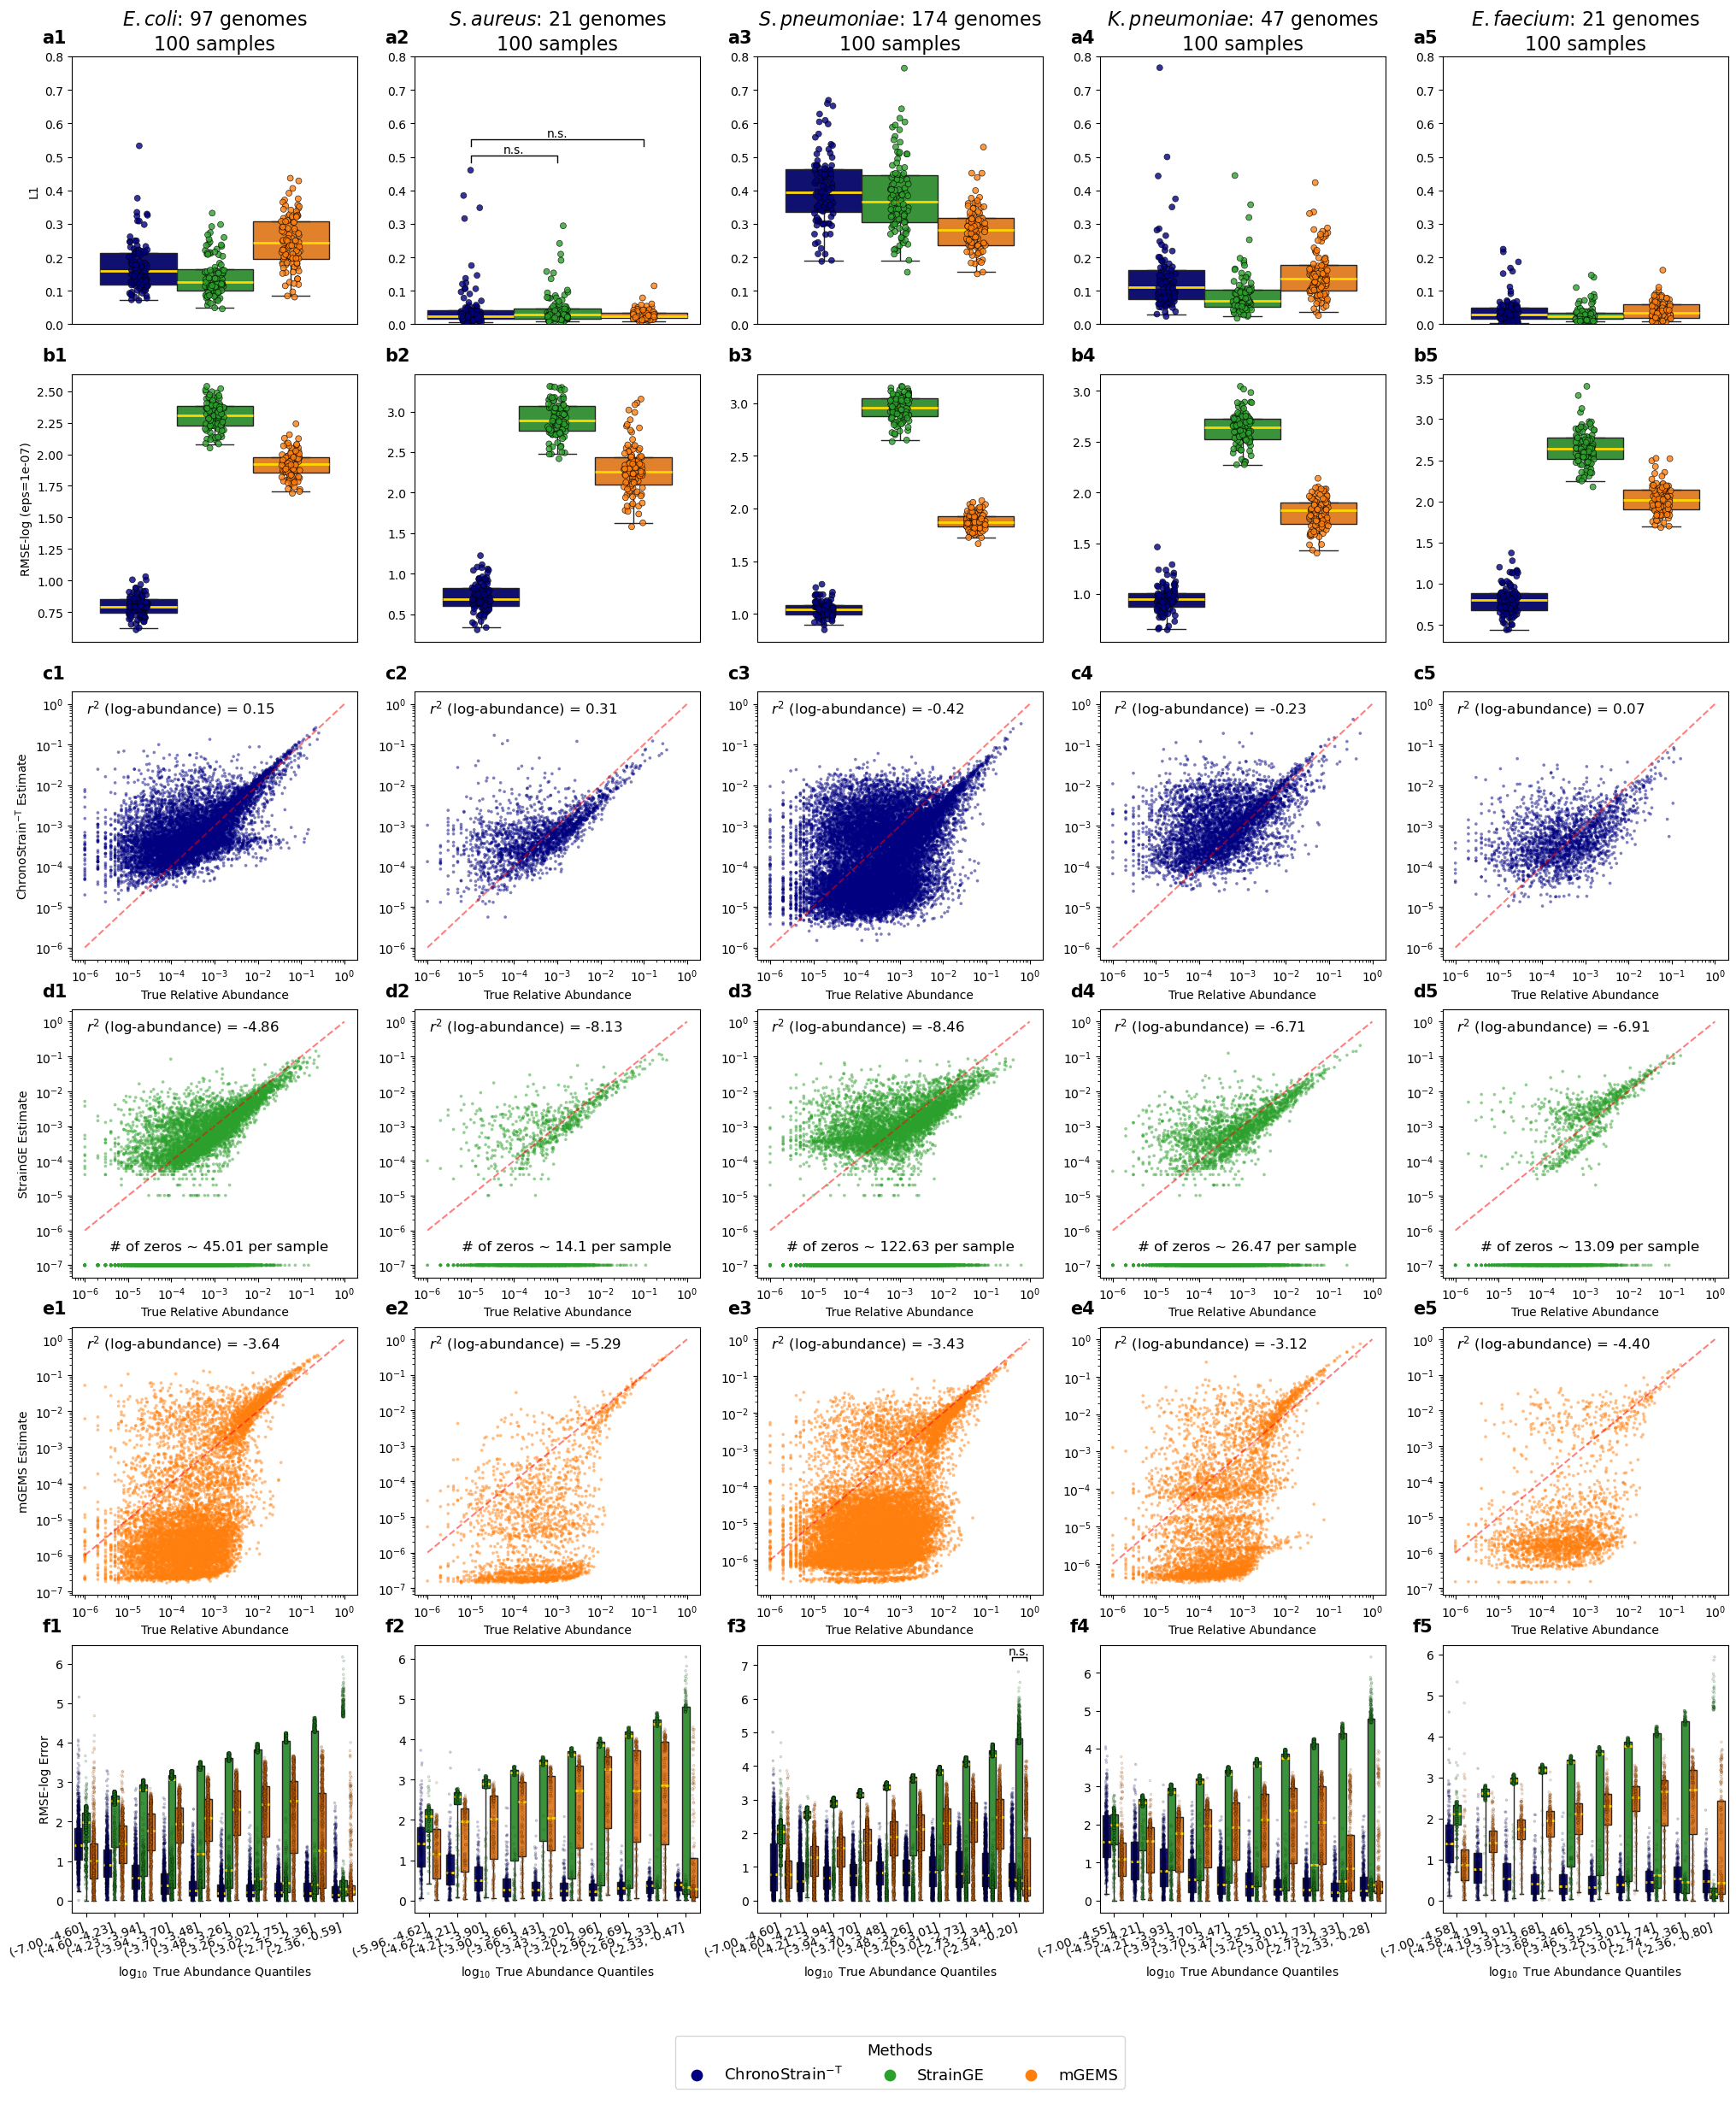

In [30]:
method_colors = {
    'ChronoStrain': 'navy',
    'mGEMS': 'tab:orange',
    'StrainGE': 'tab:green'
}
method_labels = {
    'ChronoStrain': r'ChronoStrain$^{-\rm T}$',
    'mGEMS': 'mGEMS',
    'StrainGE': 'StrainGE'
}
method_order = ['ChronoStrain', 'StrainGE', 'mGEMS']


species_to_render = ['ECOLI', 'SAUREUS', 'SPNEUMONIAE', 'KPNEUMONIAE', 'EFAECIUM']
true_gold_standard_counts = [97, 21, 174, 47, 21]
species_overall_dfs = [ecoli_df, saureus_df, spneumoniae_df, kpneumoniae_df, efaecium_df]
species_indiv_dfs = [ecoli_individual_df, saureus_individual_df, spneumoniae_individual_df, kpneumoniae_individual_df, efaecium_individual_df]
# fig, axes = plt.subplots(2, 5, figsize=(30, 12))

""" plot layout (mosaic) """
mosaic = [
    ['L1_{}'.format(s) for s in species_to_render],
    ['RMSE_log_{}'.format(s) for s in species_to_render],
    ['Scatter_{}_ChronoStrain'.format(s) for s in species_to_render],
    ['Scatter_{}_StrainGE'.format(s) for s in species_to_render],
    ['Scatter_{}_mGEMS'.format(s) for s in species_to_render],
    ['Binned_RMSE_{}'.format(s) for s in species_to_render],
    ['Legend'] * len(species_to_render)
]

""" plot size """
unit_size = 5
fig, axes = plt.subplot_mosaic(
    mosaic=mosaic,
    gridspec_kw={
        'height_ratios': ([6] * (len(mosaic) - 1)) + [3],
        'wspace': 0.2,
        'hspace': 0.2,
    },
    figsize=(unit_size * len(mosaic[0]), unit_size * (len(mosaic) - 1) + 1)
)

""" Pvalue storage """
error_pvalues = {}
binned_error_pvalues = {}

""" plot rendering """
for species_label, species_df, species_indiv_df, num_gold_standard in zip(species_to_render, species_overall_dfs, species_indiv_dfs, true_gold_standard_counts):
    species_display_name = r"$\it{{{}. {}}}$".format(species_label[0].upper(), species_label[1:].lower()) + f": {num_gold_standard} genomes" + "\n100 samples"

    # =================== Plot: overall L1 and RMSE errors.
    plot_l1_rmse(axes[f'L1_{species_label}'], axes[f'RMSE_log_{species_label}'], species_df, 'placeholder title', method_colors, method_order)
    # axes[f'Scatter_{species_label}_{first_method}'].set_title(species_display_name, fontsize=18)
    axes[f'L1_{species_label}'].set_title(species_display_name, fontsize=16)
    axes[f'L1_{species_label}'].set_ylim(0., 0.8)
    
    err_pvalue_df = compute_pvalue_df(
        species_df.assign(GROUP=f'{species_label}'),
        base_methods=['ChronoStrain'], comparator_methods=['StrainGE', 'mGEMS'], y_cols=['L1', 'RMSLE'], 
        group_by_col='GROUP'
    )
    annotate_pvalues(
        axes[f'L1_{species_label}'], err_pvalue_df, species_df.assign(GROUP=f'{species_label}'), 
        group_column='GROUP',
        column_name='L1',
        sig_level=0.05,
        method_order=method_order, marker_str="n.s.", y_offset_factor=0.05, dy=0.02, overlap_gap=0.05, show_nonsig=True, cascade_above=True
    )
    annotate_pvalues(
        axes[f'RMSE_log_{species_label}'], err_pvalue_df, species_df.assign(GROUP=f'{species_label}'), 
        group_column='GROUP',
        column_name='RMSLE',
        sig_level=0.05,
        method_order=method_order, marker_str="n.s.", y_offset_factor=0.05, dy=0.02, overlap_gap=0.05, show_nonsig=True, cascade_above=True
    )
    error_pvalues[species_label] = err_pvalue_df

    # =================== Plot: method-specific scatterplot.
    first_method = method_order[0]
    for method_name in method_order:   
        plot_truth_vs_pred(
            axes[f'Scatter_{species_label}_{method_name}'], species_indiv_df.loc[species_indiv_df['Method'] == method_name],
            eps=EPSILON_FOR_LOG_PADDING
        )

    # =================== Plot: binned errors.
    binned_indiv_df = plot_binned_differences(axes[f'Binned_RMSE_{species_label}'], species_indiv_df, log_or_linear='log', eps=EPSILON_FOR_LOG_PADDING)
    binned_pval_df = compute_pvalue_df(
        binned_indiv_df, 
        base_methods=['ChronoStrain'], 
        comparator_methods=['StrainGE', 'mGEMS'], y_cols=['Diff'], 
        group_by_col='Bin'
    )
    annotate_pvalues(
        axes[f'Binned_RMSE_{species_label}'], binned_pval_df, binned_indiv_df, 
        group_column='Bin',
        column_name='Diff',
        sig_level=0.05,
        method_order=method_order, marker_str="n.s.", y_offset_factor=0.05, dy=0.1, overlap_gap=0.4, show_nonsig=True, cascade_above=True
    )
    binned_error_pvalues[species_label] = binned_pval_df


# ===== hide some axis labels
for species_label in species_to_render[1:]:
    axes[f'L1_{species_label}'].set_ylabel(None)
    axes[f'RMSE_log_{species_label}'].set_ylabel(None)
    axes[f'Binned_RMSE_{species_label}'].set_ylabel(None)
    for method_name in method_order:
        axes[f'Scatter_{species_label}_{method_name}'].set_ylabel(None)
        # axes[f'Scatter_{species_label}_{method_name}'].set_yticklabels([])


# for species_label in species_to_render:
#     for method_name in method_order[:-1]:
#         axes[f'Scatter_{species_label}_{method_name}'].set_xlabel(None)
        # axes[f'Scatter_{species_label}_{method_name}'].set_yticklabels([])

for method_name in method_order:
    first_species = species_to_render[0]
    axes[f'Scatter_{first_species}_{method_name}'].set_ylabel("{} Estimate".format(method_labels[method_name]))
    # axes[f'Scatter_{species_label}_{method_name}'].set_yticklabels([])


""" add A/B/C/D labels """
for mosaic_row, row_label in zip(mosaic, "ABCDEFGHIJKLMNOP"):
    for ax_idx, ax_name in enumerate(mosaic_row):
        if ax_name.startswith("Legend"):
            continue
        ax_label = f"{row_label.lower()}{ax_idx + 1}"
        _ax = axes[ax_name]
        trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
        _ax.text(
            0., 1.05, ax_label, transform=_ax.transAxes + trans,
            va='bottom', fontfamily='sans-serif', weight='bold', size=15
        )


""" LEGEND """
legend_ax = axes['Legend']
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_colors[m], s=80), method_labels[m]) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", loc="lower center", ncol=len(method_order), fontsize=13, title_fontsize=13)
_ = legend_ax.axis('off')

plt.savefig("plots/gold_only_trimmed_relaxed_complete.pdf", bbox_inches='tight')

# P-values

In [43]:
for taxa_label, pvalue_table in error_pvalues.items():
    display(pvalue_table[
            [
                'GROUP', 'Method', 'Comparator',
                'Pval_L1', 'Pval_RMSLE',
                'Pval_L1_Raw', 'Pval_RMSLE_Raw',
                'Stat_L1', 'Stat_RMSLE',
            ]
    ])

,GROUP,Method,Comparator,Pval_L1,Pval_RMSLE,Pval_L1_Raw,Pval_RMSLE_Raw,Stat_L1,Stat_RMSLE
0,ECOLI,ChronoStrain,StrainGE,5.610882e-09,3.896560e-18,5.610882e-09,3.896560e-18,830.0,0.0
1,ECOLI,ChronoStrain,mGEMS,9.830178e-15,3.896560e-18,4.915089e-15,3.896560e-18,248.0,0.0


,GROUP,Method,Comparator,Pval_L1,Pval_RMSLE,Pval_L1_Raw,Pval_RMSLE_Raw,Stat_L1,Stat_RMSLE
0,SAUREUS,ChronoStrain,StrainGE,0.764838,3.896560e-18,0.764838,3.896560e-18,2438.0,0.0
1,SAUREUS,ChronoStrain,mGEMS,0.504450,3.896560e-18,0.252225,3.896560e-18,2192.0,0.0


,GROUP,Method,Comparator,Pval_L1,Pval_RMSLE,Pval_L1_Raw,Pval_RMSLE_Raw,Stat_L1,Stat_RMSLE
0,SPNEUMONIAE,ChronoStrain,StrainGE,3.746988e-05,3.896560e-18,3.746988e-05,3.896560e-18,1326.0,0.0
1,SPNEUMONIAE,ChronoStrain,mGEMS,1.423416e-17,3.896560e-18,7.117078e-18,3.896560e-18,20.0,0.0


,GROUP,Method,Comparator,Pval_L1,Pval_RMSLE,Pval_L1_Raw,Pval_RMSLE_Raw,Stat_L1,Stat_RMSLE
0,KPNEUMONIAE,ChronoStrain,StrainGE,1.520285e-14,3.896560e-18,7.601423e-15,3.896560e-18,264.0,0.0
1,KPNEUMONIAE,ChronoStrain,mGEMS,1.112362e-04,3.896560e-18,1.112362e-04,3.896560e-18,1401.0,0.0


,GROUP,Method,Comparator,Pval_L1,Pval_RMSLE,Pval_L1_Raw,Pval_RMSLE_Raw,Stat_L1,Stat_RMSLE
0,EFAECIUM,ChronoStrain,StrainGE,0.028260,3.896560e-18,0.028260,3.896560e-18,1887.0,0.0
1,EFAECIUM,ChronoStrain,mGEMS,0.001216,3.896560e-18,0.000608,3.896560e-18,1528.0,0.0


In [49]:
for taxa_label, pvalue_table in binned_error_pvalues.items():
    print(taxa_label)
    display(pvalue_table[
            [
                'Bin', 'Method', 'Comparator',
                'Pval_Diff', 'Pval_Diff_Raw', 'Stat_Diff'
            ]
    ])

ECOLI


,Bin,Method,Comparator,Pval_Diff,Pval_Diff_Raw,Stat_Diff
0,"(-7.001, -4.6]",ChronoStrain,StrainGE,1.774355e-39,1.508202e-39,127804.0
1,"(-7.001, -4.6]",ChronoStrain,mGEMS,1.562380e-34,1.406142e-34,135892.0
2,"(-4.6, -4.228]",ChronoStrain,StrainGE,8.245564e-106,3.298225e-106,43291.0
3,"(-4.6, -4.228]",ChronoStrain,mGEMS,9.562196e-41,7.649756e-41,116847.0
4,"(-4.228, -3.939]",ChronoStrain,StrainGE,9.650619e-102,4.342778e-102,49023.0
5,"(-4.228, -3.939]",ChronoStrain,mGEMS,3.471306e-120,1.041392e-120,32253.0
6,"(-3.939, -3.703]",ChronoStrain,StrainGE,7.088932e-88,4.253359e-88,57540.0
7,"(-3.939, -3.703]",ChronoStrain,mGEMS,3.092587e-140,7.731468e-141,12136.0
8,"(-3.703, -3.48]",ChronoStrain,StrainGE,5.483175e-93,3.015746e-93,58163.0
9,"(-3.703, -3.48]",ChronoStrain,mGEMS,1.978651e-150,2.967976e-151,7768.0


SAUREUS


,Bin,Method,Comparator,Pval_Diff,Pval_Diff_Raw,Stat_Diff
0,"(-5.96, -4.618]",ChronoStrain,StrainGE,5.195337e-17,4.156270e-17,3770.0
1,"(-5.96, -4.618]",ChronoStrain,mGEMS,2.430334e-03,2.308817e-03,8564.0
2,"(-4.618, -4.214]",ChronoStrain,StrainGE,3.248128e-33,1.136845e-33,386.0
3,"(-4.618, -4.214]",ChronoStrain,mGEMS,1.920954e-13,1.632811e-13,4516.0
4,"(-4.214, -3.903]",ChronoStrain,StrainGE,2.064116e-34,2.221974e-35,189.0
5,"(-4.214, -3.903]",ChronoStrain,mGEMS,9.318083e-27,6.522658e-27,1684.0
6,"(-3.903, -3.66]",ChronoStrain,StrainGE,4.387233e-32,1.974255e-32,533.0
7,"(-3.903, -3.66]",ChronoStrain,mGEMS,3.713664e-29,2.228198e-29,1054.0
8,"(-3.66, -3.427]",ChronoStrain,StrainGE,2.991309e-33,8.973926e-34,398.0
9,"(-3.66, -3.427]",ChronoStrain,mGEMS,1.217930e-32,4.871719e-33,521.0


SPNEUMONIAE


,Bin,Method,Comparator,Pval_Diff,Pval_Diff_Raw,Stat_Diff
0,"(-7.001, -4.6]",ChronoStrain,StrainGE,2.796000e-177,2.097000e-177,170733.0
1,"(-7.001, -4.6]",ChronoStrain,mGEMS,2.733610e-09,2.596929e-09,650944.0
2,"(-4.6, -4.215]",ChronoStrain,StrainGE,9.851622e-266,4.925811e-267,19877.0
3,"(-4.6, -4.215]",ChronoStrain,mGEMS,2.018557e-79,1.715773e-79,349031.0
4,"(-4.215, -3.935]",ChronoStrain,StrainGE,5.261610e-265,5.261610e-266,27923.0
5,"(-4.215, -3.935]",ChronoStrain,mGEMS,5.010757e-182,3.256992e-182,155354.0
6,"(-3.935, -3.699]",ChronoStrain,StrainGE,5.728773e-255,8.593159e-256,43779.0
7,"(-3.935, -3.699]",ChronoStrain,mGEMS,8.817235e-218,4.408617e-218,99625.0
8,"(-3.699, -3.477]",ChronoStrain,StrainGE,1.978484e-241,3.956967e-242,58369.0
9,"(-3.699, -3.477]",ChronoStrain,mGEMS,3.317346e-229,1.161071e-229,76560.0


KPNEUMONIAE


,Bin,Method,Comparator,Pval_Diff,Pval_Diff_Raw,Stat_Diff
0,"(-7.001, -4.551]",ChronoStrain,StrainGE,1.442018e-06,1.369917e-06,43426.0
1,"(-7.001, -4.551]",ChronoStrain,mGEMS,4.571428e-25,3.428571e-25,26477.0
2,"(-4.551, -4.214]",ChronoStrain,StrainGE,1.318750e-48,5.934377e-49,11537.0
3,"(-4.551, -4.214]",ChronoStrain,mGEMS,1.142056e-06,1.027851e-06,40006.0
4,"(-4.214, -3.928]",ChronoStrain,StrainGE,3.080493e-52,9.241480e-53,10030.0
5,"(-4.214, -3.928]",ChronoStrain,mGEMS,7.523492e-24,6.018794e-24,25192.0
6,"(-3.928, -3.697]",ChronoStrain,StrainGE,3.636190e-54,9.090474e-55,9248.0
7,"(-3.928, -3.697]",ChronoStrain,mGEMS,2.055757e-41,1.130666e-41,15284.0
8,"(-3.697, -3.469]",ChronoStrain,StrainGE,3.965298e-49,1.586119e-49,11564.0
9,"(-3.697, -3.469]",ChronoStrain,mGEMS,3.330003e-59,6.660007e-60,7087.0


EFAECIUM


,Bin,Method,Comparator,Pval_Diff,Pval_Diff_Raw,Stat_Diff
0,"(-7.001, -4.583]",ChronoStrain,StrainGE,8.025077e-18,5.617554e-18,3667.0
1,"(-7.001, -4.583]",ChronoStrain,mGEMS,1.056248e-10,8.978104e-11,5623.0
2,"(-4.583, -4.186]",ChronoStrain,StrainGE,5.974473e-34,1.792342e-34,254.0
3,"(-4.583, -4.186]",ChronoStrain,mGEMS,2.523121e-15,1.892341e-15,4015.0
4,"(-4.186, -3.913]",ChronoStrain,StrainGE,1.275369e-33,4.463792e-34,319.0
5,"(-4.186, -3.913]",ChronoStrain,mGEMS,9.732756e-31,5.353016e-31,838.0
6,"(-3.913, -3.676]",ChronoStrain,StrainGE,5.689110e-34,1.422277e-34,294.0
7,"(-3.913, -3.676]",ChronoStrain,mGEMS,5.689110e-34,1.254957e-34,285.0
8,"(-3.676, -3.459]",ChronoStrain,StrainGE,1.895781e-31,9.478904e-32,647.0
9,"(-3.676, -3.459]",ChronoStrain,mGEMS,1.840841e-33,7.363362e-34,298.0
